## 一、 将分钟数据输入HFDataView(1-5月的BHC数据)
1. 初始化不同周期的DataView
2. 读取Excel数据并合并数据
3. 处理数据格式，需要传入一个multiindex的数据，用来初始化dv。
4. 合成不同周期的数据并传入对应的DataView

## 1. 初始化不同周期的DataView

In [1]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1 = HFDataView()
dv5 = HFDataView()
dv15 = HFDataView()
dv30 = HFDataView()
dv60 = HFDataView()
dv240 = HFDataView()
dv480 = HFDataView()

## 2. 读取Excel数据并合并数据

In [2]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
data_excel = pd.read_csv('bch_usdt.csv')

## 3. 处理数据格式，需要传入一个multiindex的数据，用来初始化dv。
要求:trade_date、symbol为index， fields为columns. 其中,trade_date要为整数类型

In [4]:
data_excel["trade_date"] = data_excel["time"].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
data_excel["symbol"] = "btc_usdt"
data_excel['usdt'] = 6.4
data_excel = data_excel.set_index(["trade_date","symbol"])
dv1.create_init_dv(data_excel) # 用来初始化dv

Initialize dataview success.


## 4. 合成不同周期的数据并传入对应的DataView
1. 用resample合并成不同周期的Bar数据
2. 传入对应的DataView

In [5]:
data_time = data_excel.set_index('time').dropna()

In [6]:
TimePeriodDict = {t:data_time.resample(t).agg({'high':'max','open':'first','close':'last','low':'min','volume':'sum','amount':'sum'}).dropna() for t in ['5Min', '15Min', "30Min", '1H', '4H', '8H']}

In [7]:
def Time_Dict(t_list=['5Min', '15Min', "30Min", '1H', '4H', '8H']):
    for t in t_list:
        TimePeriodDict[t]['time'] = TimePeriodDict[t].index
        TimePeriodDict[t]["trade_date"] = TimePeriodDict[t]['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
        TimePeriodDict[t]["symbol"] = "btc_usdt"
        TimePeriodDict[t]['usdt'] = 6.4
        TimePeriodDict[t] = TimePeriodDict[t].set_index(["trade_date","symbol"])
    return TimePeriodDict

In [8]:
Time_dict = Time_Dict()

In [9]:
dv5.create_init_dv(Time_dict['5Min'])
dv15.create_init_dv(Time_dict['15Min'])
dv30.create_init_dv(Time_dict['30Min'])
dv60.create_init_dv(Time_dict['1H'])
dv240.create_init_dv(Time_dict['4H'])
dv480.create_init_dv(Time_dict['8H'])

Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.


## 二、计算不同周期的Alpha指标

### 计算VWAP

In [10]:
for dv in [dv1, dv5, dv15, dv30, dv60, dv240, dv480]:
    dv.add_formula('vwap_c','amount/(volume*usdt)', add_data=True)

### 计算Alpha1

In [11]:
 for dv in [dv1, dv5, dv15, dv30, dv60, dv240, dv480]:
        dv.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)

## 三、 TimingDigger的使用案例

In [12]:
import talib as ta
import matplotlib.pyplot as plt

def Plot_MA(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(ta.MA(alpha.values, ShortPeriod), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(ta.MA(alpha.values, LongPeriod), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [13]:
# dv5.get_ts('alpha1_C', date_type='datetime')

In [14]:
dv_dict = {'alpha1_dv1':dv1, 'alpha1_dv5': dv5, 'alpha1_dv15':dv15, 'alpha1_dv30':dv30, 'alpha1_dv60':dv60, 'alpha1_dv240':dv240, 'alpha1_dv480':dv480}
alpha1_dict = {n: dv.get_ts('alpha1_C', date_type='datetime').btc_usdt for n, dv in dv_dict.items()}

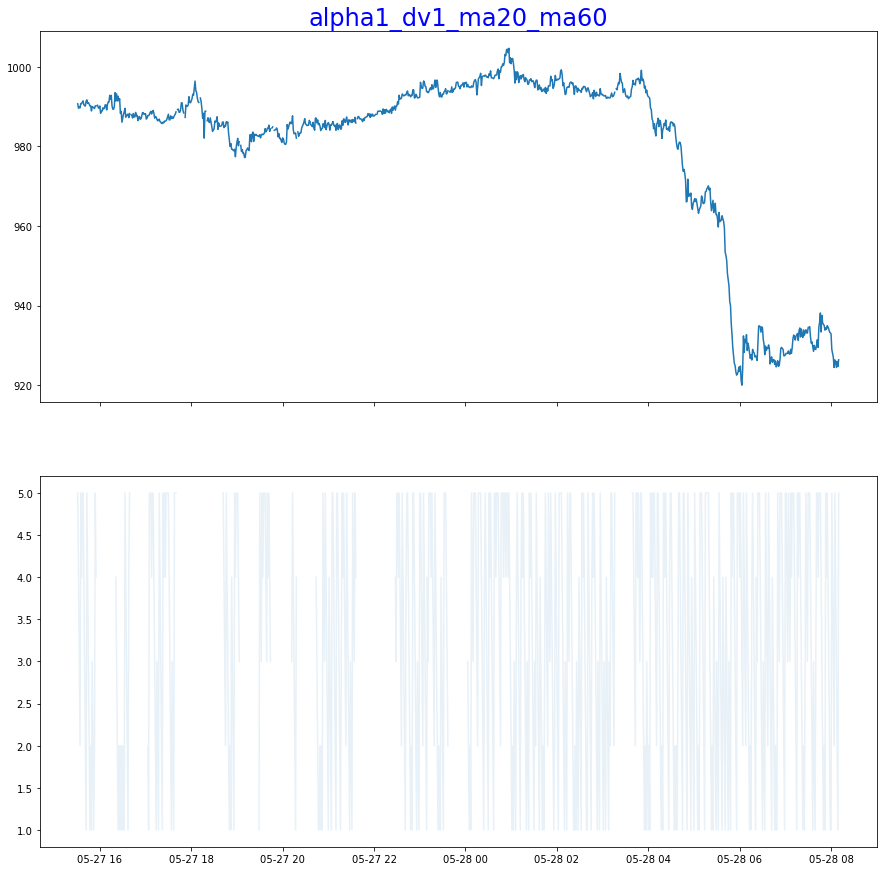

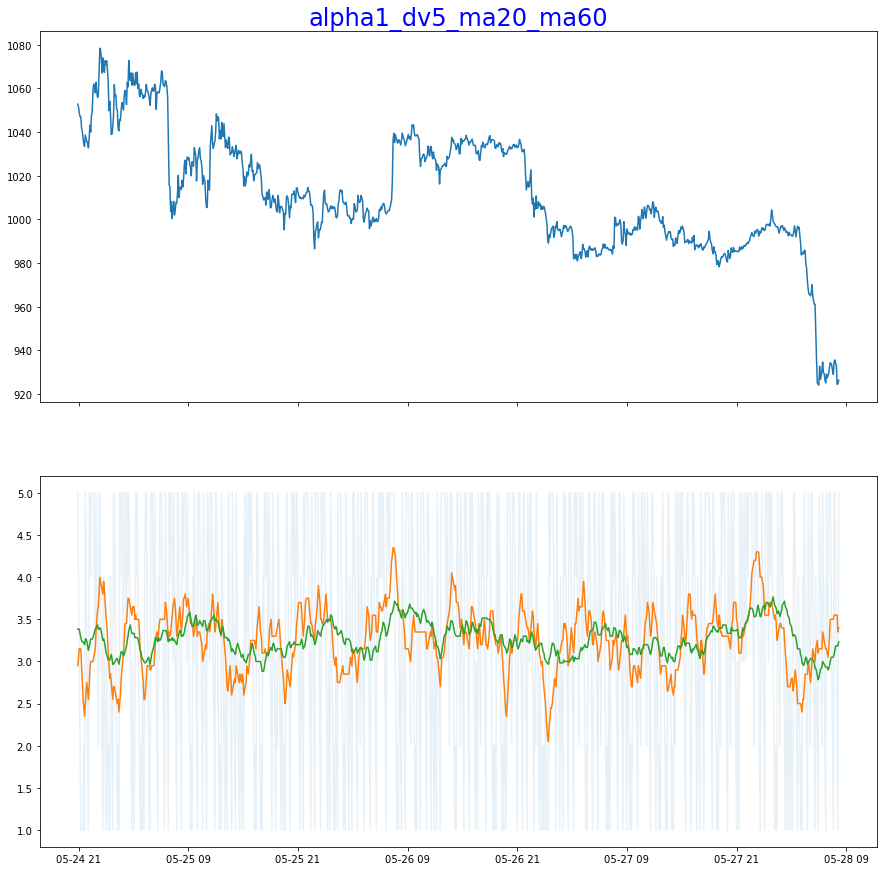

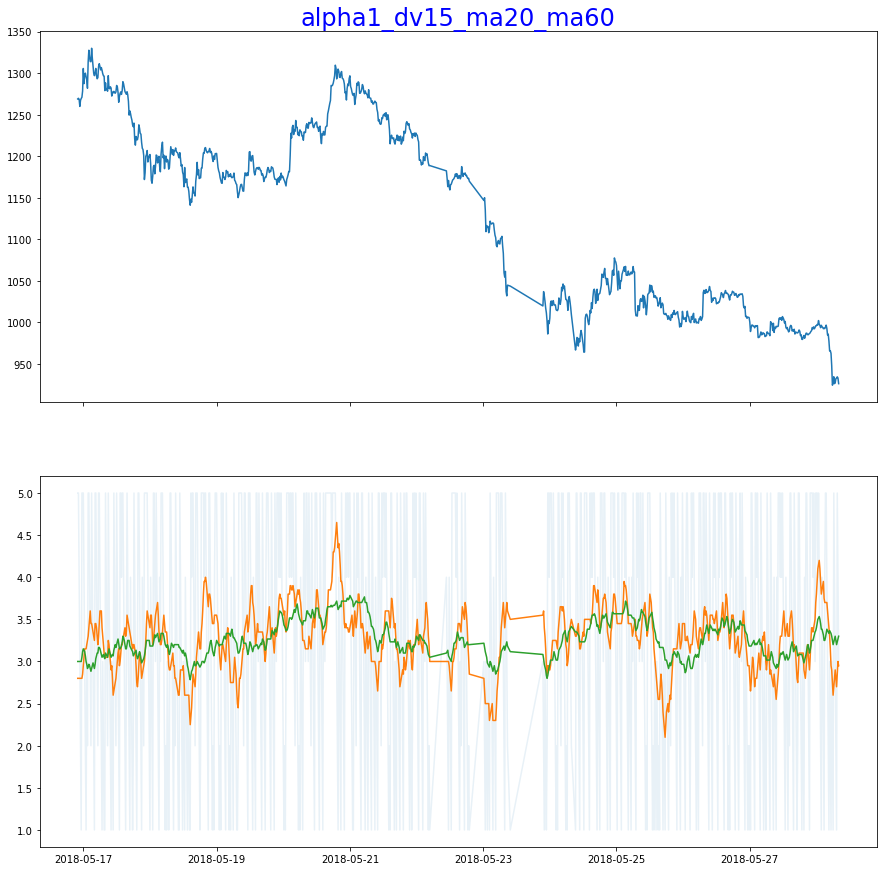

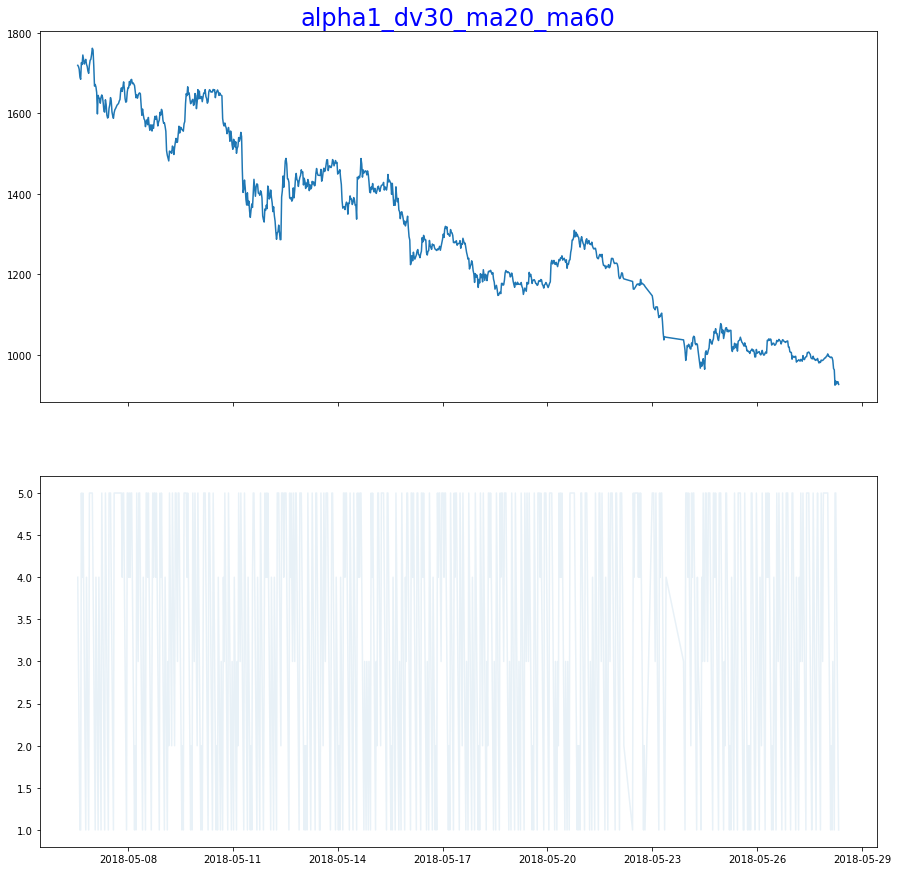

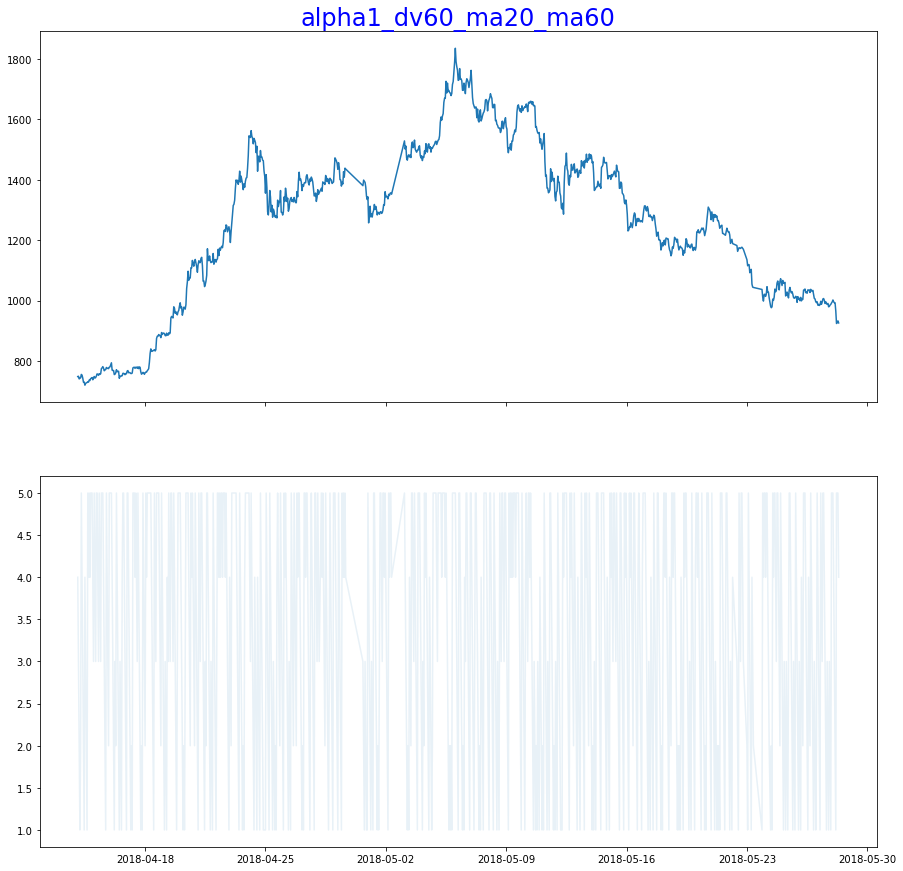

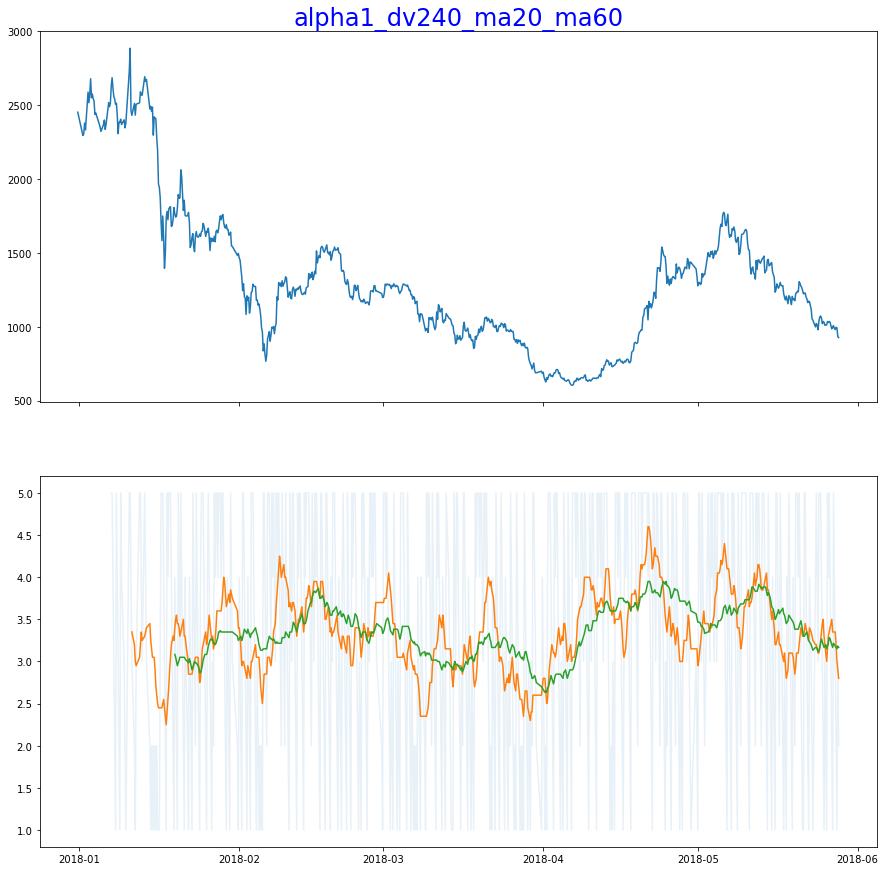

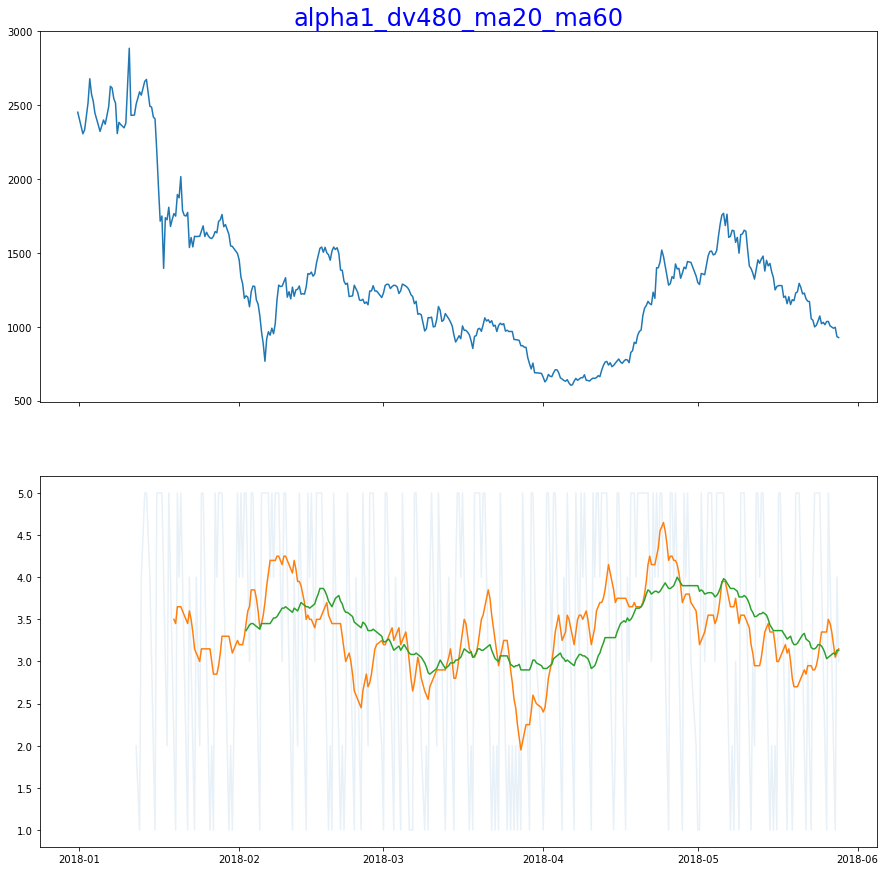

In [15]:
for name, alpha in alpha1_dict.items():
    Plot_MA(globals()[name.split('_')[1]], alpha, chart_name=name+'_ma20_ma60',ShortPeriod=20, LongPeriod=60, n=-1000)

## 假设 Alpha1在8H下的MA20与MA60金叉死叉收益为0

In [42]:
# 进场信号
long = dv480.add_formula("long","If((Ts_Mean(alpha1_C,20)>Ts_Mean(alpha1_C,60)) && (Delay(Ts_Mean(alpha1_C,20),1)<Delay(Ts_Mean(alpha1_C,60),1)),2,0)", add_data=True)
short = dv480.add_formula("short","If((Ts_Mean(alpha1_C,20)<Ts_Mean(alpha1_C,60)) && (Delay(Ts_Mean(alpha1_C,20),1)>Delay(Ts_Mean(alpha1_C,60),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv480.add_formula("close_long","If(short==-2,1,0)", add_data=True)
close_short = dv480.add_formula("close_short","If(long==2,-1,0)", add_data=True)

# 汇总
enter = dv480.add_formula("enter","long+short", add_data=True)
exit = dv480.add_formula("exit","close_long+close_short", add_data=True) 

Field [long] is overwritten.
Field [short] is overwritten.
Field [close_long] is overwritten.
Field [close_short] is overwritten.


In [51]:
from jaqs_fxdayu.research import TimingDigger

# step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称
td1 = TimingDigger(output_folder=".", output_format='pdf')

# 多空分别计算一遍 输出汇总结果
# td1.process_signal(
#     enter_signal=dv480.get_ts("enter"),
#     exit_signal=dv480.get_ts("exit"),
#     sig_type="long",  # 信号类型 long/short
#     price=dv480.get_ts("close"),
#     max_holding_period=100,  # 最大持有天数 可为空
#     stoploss=-0.5,  # 止损百分比 负数 可为空
#     stopprofit=0.8,  # 止盈百分比 正数 可为空
# )

#多空分别计算一遍 输出汇总结果
td1.process_signal(
    enter_signal=dv480.get_ts("short"),
    exit_signal=dv480.get_ts("close_short"),
    sig_type="short",  # 信号类型 long/short
    price=dv480.get_ts("close"),
    max_holding_period=100,  # 最大持有天数 可为空
    stoploss=-0.01,  # 止损百分比 负数 可为空
    stopprofit=0.03,  # 止盈百分比 正数 可为空
)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%


In [47]:
td1.create_event_report(sig_type="long",
                       by_symbol=True)

Figure saved: E:\Factor_Scripts\factor-scripts\Alpha101\Alpha_Indicators_Example\long_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                         win   loss     all
t-stat                   NaN -3.652   0.675
p-value                  NaN  0.067   0.548
mean                0.978000 -0.086   0.180
std                 0.000000  0.033   0.462
info_ratio               inf -2.582   0.390
skewness            0.000000 -0.538   1.141
kurtosis           -3.000000 -1.500  -0.677
pct5                0.978000 -0.126  -0.123
pct25               0.978000 -0.102  -0.088
pct50               0.978000 -0.073  -0.063
pct75               0.978000 -0.063   0.204
pct95               0.978000 -0.056   0.824
occurance           1.000000  3.000   4.000
win_ratio                NaN    NaN   0.250
win_mean/loss_mean       NaN    NaN  11.355


In [52]:
td1.create_event_report(sig_type="short",
                       by_symbol=True)

Figure saved: E:\Factor_Scripts\factor-scripts\Alpha101\Alpha_Indicators_Example\short_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                      win   loss    all
t-stat              2.097 -2.692 -0.468
p-value             0.171  0.115  0.660
mean                0.035 -0.058 -0.011
std                 0.024  0.030  0.054
info_ratio          1.483 -1.903 -0.209
skewness           -0.673 -0.198 -0.205
kurtosis           -1.500 -1.500 -1.239
pct5                0.007 -0.093 -0.086
pct25               0.025 -0.075 -0.046
pct50               0.049 -0.054 -0.011
pct75               0.052 -0.038  0.037
pct95               0.055 -0.026  0.054
occurance           3.000  3.000  6.000
win_ratio             NaN    NaN  0.500
win_mean/loss_mean    NaN    NaN  0.610


In [23]:
td1.create_event_report(sig_type="long_short",
                       by_symbol=True)

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              1.966 -3.127   1.091
p-value             0.121  0.035   0.304
mean                0.332 -0.097   0.118
std                 0.338  0.062   0.324
info_ratio          0.983 -1.563   0.364
skewness            1.182 -0.557   1.712
kurtosis           -0.110 -1.097   2.160
pct5                0.032 -0.185  -0.169
pct25               0.151 -0.132  -0.068
pct50               0.241 -0.073  -0.012
pct75               0.288 -0.054   0.218
pct95               0.840 -0.031   0.668
occurance           5.000  5.000  10.000
win_ratio             NaN    NaN   0.500
win_mean/loss_mean    NaN    NaN   3.438
